In [2]:
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=f81153dfcdcd0b8a441e58045f8274fafa04add0576a11d144c10cc56c3b290a
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [3]:
! pip install torchinfo

In [4]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.6 MB/s eta 0:00:00


## Importing libraries

In [5]:
from torchvision import transforms
from torch.utils.data import ConcatDataset
from medmnist import OCTMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns
from PIL import Image
import time
from torchmetrics import Accuracy
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.image as mpimg
import random
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsummary import summary
import h5py


In [6]:
# normalize the dataset
a = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
total_dataset = ConcatDataset([
    OCTMNIST(split="train", download=True, transform=a),
    OCTMNIST(split="val", download=True, transform=a),
    OCTMNIST(split="test", download=True, transform=a)
])

100%|██████████| 54938180/54938180 [00:03<00:00, 16978116.98it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [7]:
train_size = int(0.7 * len(total_dataset))
val_size = int(0.15 * len(total_dataset))
test_size = len(total_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    total_dataset, [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

labels = set()
for dataset in total_dataset.datasets:
    labels.update(map(tuple, dataset.labels))
num_classes = len(labels)

print("Number of classes in the dataset:", num_classes)
print("Length of combined dataset",len(total_dataset))
print("Length of train_size:", len(train_dataset))
print("Length of val_size:", len(val_dataset))
print("Length of test_size:", len(test_dataset))



Number of classes in the dataset: 4
Length of combined dataset 109309
Length of train_size: 76516
Length of val_size: 16396
Length of test_size: 16397


In [ ]:
class modelCNN(nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.fclayers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 36)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = modelCNN()
model=model.to(device)
print(model)

summary(model,input_size=(1, 28, 28))


cuda
modelCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=36, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.8)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses=[]
    train_accuracy=[]
    val_losses=[]
    val_accuracies = []

    for epoch in range(5):
        model.train()
        running_loss = 0
        total=0
        correct=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total =  total + labels.size(0)
            correct =  correct + (predicted == labels).sum().item()
            running_loss = running_loss + loss.item()
        train_accuracy.append(correct*100 // total)
        train_losses.append(running_loss / len(train_loader))
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              labels = labels.squeeze(1)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total =  total + labels.size(0)
              correct =  correct + (predicted == labels).sum().item()


        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracy[-1]), ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

Epoch: 1  Train Accuracy: 65.00%  Train Loss: 0.9249493231043768  Validation Accuracy: 68.22%  Validation Loss: 0.870795430376372
Epoch: 2  Train Accuracy: 72.00%  Train Loss: 0.7737938075460319  Validation Accuracy: 72.94%  Validation Loss: 0.7393545386624244
Epoch: 3  Train Accuracy: 76.00%  Train Loss: 0.6714093720284992  Validation Accuracy: 76.77%  Validation Loss: 0.6527218325824589
Epoch: 4  Train Accuracy: 78.00%  Train Loss: 0.6010303902486495  Validation Accuracy: 77.60%  Validation Loss: 0.6290798254514018
Epoch: 5  Train Accuracy: 80.00%  Train Loss: 0.559074759308909  Validation Accuracy: 79.94%  Validation Loss: 0.5634789981730717
Accuracy of test: 80 %
Loss of the test: 0.5573011954470831


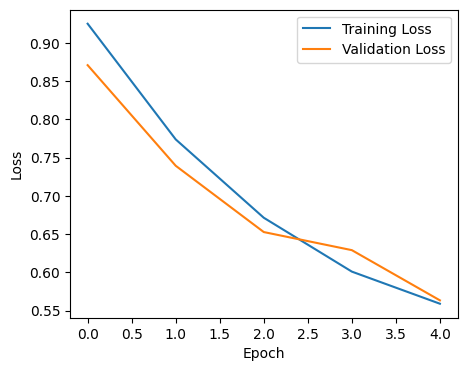

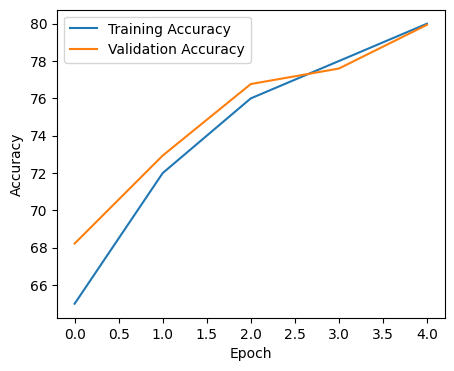

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=10)

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss=0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of test:', correct*100 // total,"%")
    print('Loss of the test:',test_loss/len(test_loader))

test_accuracy(model, test_loader)

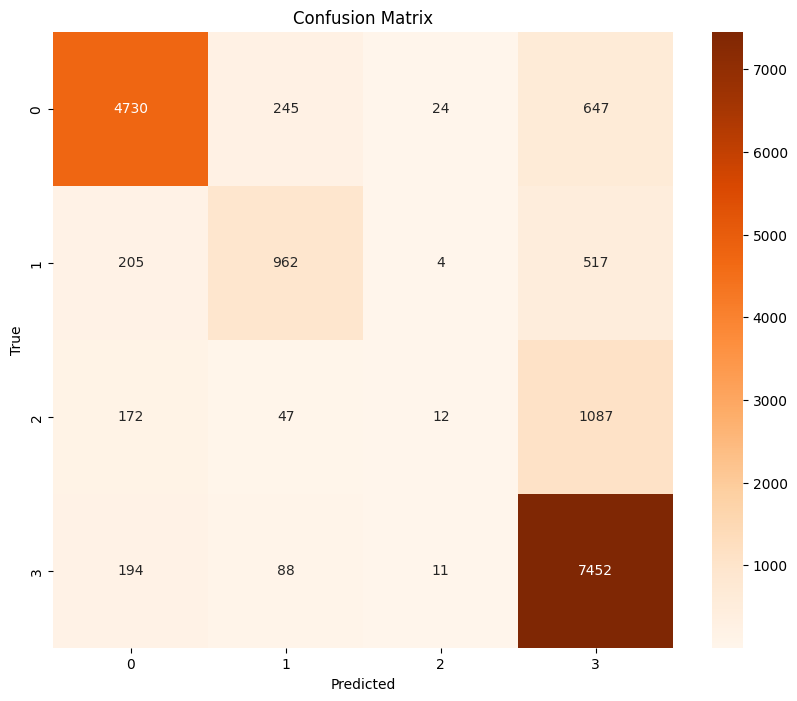

In [ ]:
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)


In [ ]:
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)


Precision: 0.76
Recall: 0.80
F1 Score: 0.77


## Early Stopping

In [ ]:
class modelCNN(nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.fclayers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 36)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = modelCNN()
model=model.to(device)
print(model)
summary(model,input_size=(1, 28, 28))

cpu
modelCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=36, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14] 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.8)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5, patience=3):
    train_losses=[]
    train_accuracy=[]
    val_losses=[]
    val_accuracies = []

    best_val_loss = float('inf')
    count = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        total=0
        correct=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total =  total + labels.size(0)
            correct =  correct + (predicted == labels).sum().item()
            running_loss = running_loss + loss.item()
        train_accuracy.append(correct*100 // total)
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              labels = labels.squeeze(1)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total =  total + labels.size(0)
              correct =  correct + (predicted == labels).sum().item()


        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            count = 0
        else:
            count += 1
            if count >= patience:
                print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.')
                break

        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracy[-1]), ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 48.00%  Train Loss: 1.1850123705473232  Validation Accuracy: 49.35%  Validation Loss: 1.1949947476387024
Epoch: 2  Train Accuracy: 62.00%  Train Loss: 0.981476972558626  Validation Accuracy: 73.27%  Validation Loss: 0.7753737218649007
Epoch: 3  Train Accuracy: 74.00%  Train Loss: 0.7340670645386479  Validation Accuracy: 75.51%  Validation Loss: 0.6974750664447532
Epoch: 4  Train Accuracy: 77.00%  Train Loss: 0.6387162255652772  Validation Accuracy: 79.24%  Validation Loss: 0.6019091630492229
Epoch: 5  Train Accuracy: 80.00%  Train Loss: 0.5569299939758203  Validation Accuracy: 81.84%  Validation Loss: 0.5174735786849887
Accuracy of test: 81 %
Loss of the test 0.5265661876953066


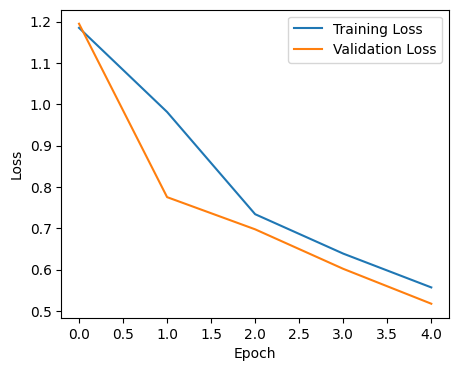

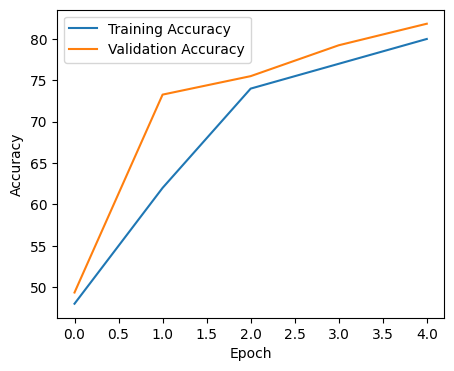

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss=0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of test:', correct*100 // total,"%")
    print('Loss of the test',test_loss/len(test_loader))

test_accuracy(model, test_loader)

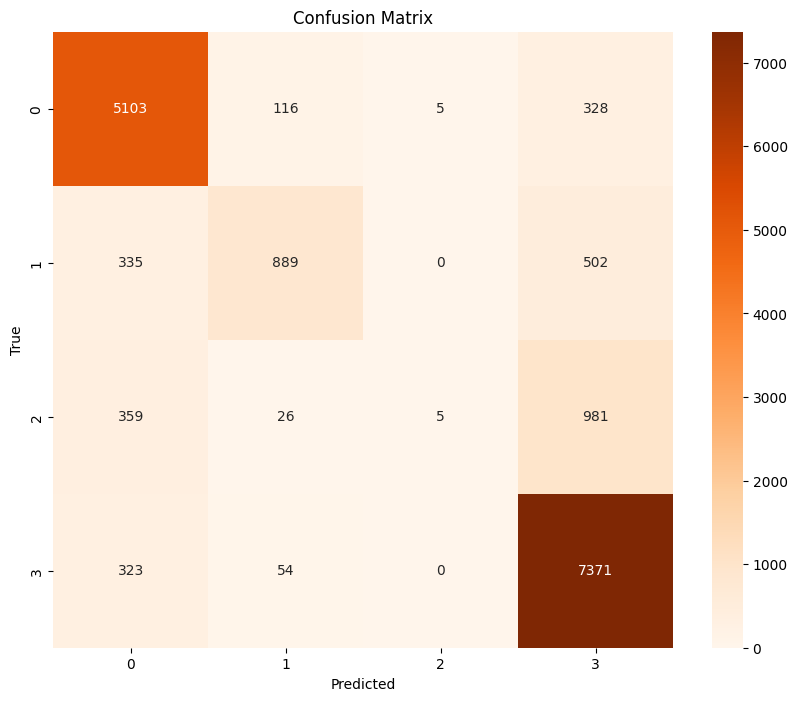

In [ ]:
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)


In [ ]:
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)


Precision: 0.79
Recall: 0.82
F1 Score: 0.77


## Dropout

In [ ]:
class modelCNN(nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.fclayers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 36),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = modelCNN()
model=model.to(device)
print(model)

summary(model,input_size=(1, 28, 28))

cuda
modelCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=36, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=20):
    train_losses=[]
    train_accuracy=[]
    val_losses=[]
    val_accuracies = []

    for epoch in range(20):
        model.train()
        running_loss = 0
        total=0
        correct=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total =  total + labels.size(0)
            correct =  correct + (predicted == labels).sum().item()
            running_loss = running_loss + loss.item()
        train_accuracy.append(correct*100 // total)
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              labels = labels.squeeze(1)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total =  total + labels.size(0)
              correct =  correct + (predicted == labels).sum().item()


        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracy[-1]), ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])


    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

Epoch: 1  Train Accuracy: 53.00%  Train Loss: 1.883796702758923  Validation Accuracy: 80.39%  Validation Loss: 0.9257597334190102
Epoch: 2  Train Accuracy: 62.00%  Train Loss: 1.6465374020031065  Validation Accuracy: 81.92%  Validation Loss: 0.9286854060707389
Epoch: 3  Train Accuracy: 64.00%  Train Loss: 1.5832480321759763  Validation Accuracy: 83.83%  Validation Loss: 0.8179743190219894
Epoch: 4  Train Accuracy: 65.00%  Train Loss: 1.5536657745722544  Validation Accuracy: 84.08%  Validation Loss: 0.829086612750584
Epoch: 5  Train Accuracy: 66.00%  Train Loss: 1.5416787548308388  Validation Accuracy: 83.62%  Validation Loss: 0.8666302302004298
Epoch: 6  Train Accuracy: 66.00%  Train Loss: 1.5229538657194794  Validation Accuracy: 84.87%  Validation Loss: 0.7799186563909286
Epoch: 7  Train Accuracy: 66.00%  Train Loss: 1.5198014337681607  Validation Accuracy: 84.59%  Validation Loss: 0.7611466763316426
Epoch: 8  Train Accuracy: 67.00%  Train Loss: 1.5004189323422104  Validation Accuracy

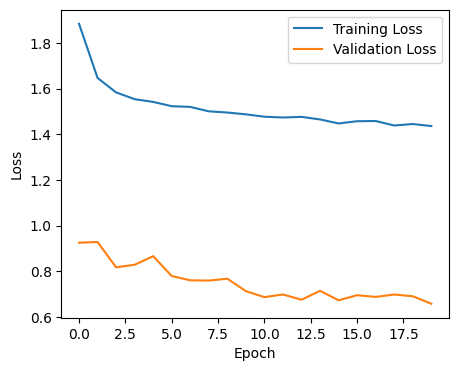

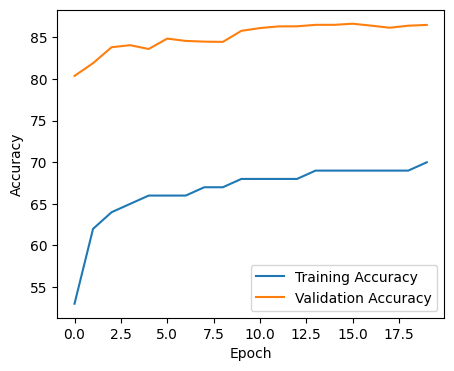

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=20)

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss=0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of test:', correct*100 // total,"%")
    print('Loss of the test',test_loss/len(test_loader))

test_accuracy(model, test_loader)

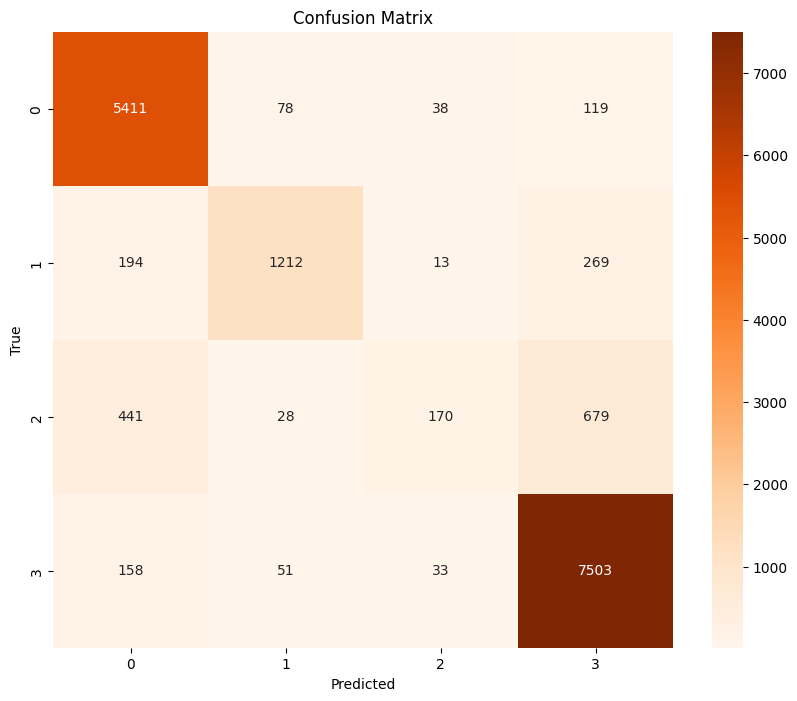

In [ ]:
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)


In [ ]:
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)


Precision: 0.86
Recall: 0.87
F1 Score: 0.85


## L2 regularization

In [8]:
class modelCNN(nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.fclayers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 36)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = modelCNN()
model=model.to(device)
print(model)
summary(model,input_size=(1, 28, 28))

cpu
modelCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=36, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14] 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=1e-5)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses=[]
    train_accuracy=[]
    val_losses=[]
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        total=0
        correct=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total =  total + labels.size(0)
            correct =  correct + (predicted == labels).sum().item()
            running_loss = running_loss + loss.item()
        train_accuracy.append(correct*100 // total)
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              labels = labels.squeeze(1)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total =  total + labels.size(0)
              correct =  correct + (predicted == labels).sum().item()


        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracy[-1]), ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])


    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

Epoch: 1  Train Accuracy: 73.00%  Train Loss: 0.7144040752164895  Validation Accuracy: 80.50%  Validation Loss: 0.5500144627423602
Epoch: 2  Train Accuracy: 83.00%  Train Loss: 0.4826738174668323  Validation Accuracy: 83.45%  Validation Loss: 0.46918452278881223
Epoch: 3  Train Accuracy: 84.00%  Train Loss: 0.43064571989320194  Validation Accuracy: 82.86%  Validation Loss: 0.47870013135184575
Epoch: 4  Train Accuracy: 85.00%  Train Loss: 0.40222641747183224  Validation Accuracy: 85.23%  Validation Loss: 0.420038628033163
Epoch: 5  Train Accuracy: 86.00%  Train Loss: 0.3788990464721834  Validation Accuracy: 85.84%  Validation Loss: 0.40932042827170184
Accuracy of test: 85 %
Loss of the test 0.4017099796102205


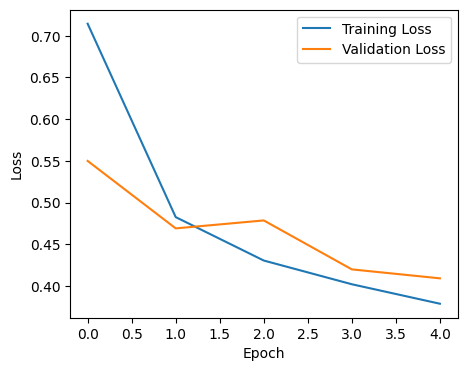

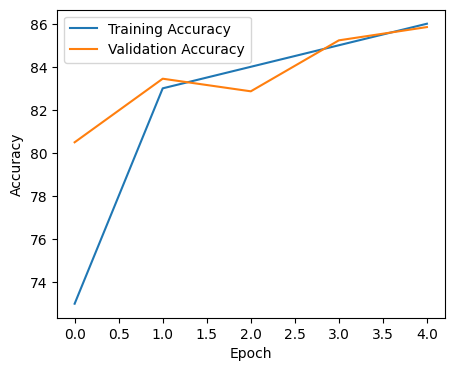

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss=0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of test:', correct*100 // total,"%")
    print('Loss of the test',test_loss/len(test_loader))

test_accuracy(model, test_loader)

In [ ]:
model_weights1 = model.state_dict()

with h5py.File('dharmaac_assignment0_part3.h5', 'w') as file:
    for name, param in model.state_dict().items():
        file.create_dataset(name, data=param.cpu().numpy())

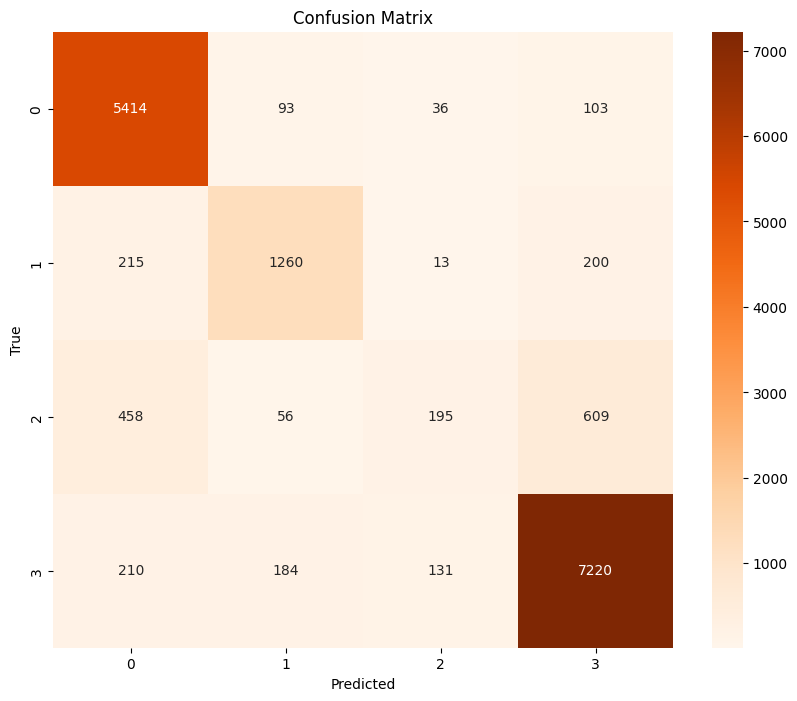

In [ ]:
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)


In [ ]:
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)


Precision: 0.84
Recall: 0.86
F1 Score: 0.84


 References:

 https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

 https://en.wikipedia.org/wiki/Early_stopping

 https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

 https://scikit-learn.org/stable/